In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('improvisations.json', orient='records')
df.groupby(df.method).time.mean()

method
GAN             688.34
MusicVAE0.1   3,730.23
MusicVAE0.3   3,797.01
MusicVAE0.6   3,801.19
Name: time, dtype: float64

In [3]:
def make_pianoroll(frame, columns):
    def expand(row):
        melodies = []
        for c in columns:
            melody = pd.DataFrame(row[c])
            melody.duration = np.round(melody.duration / 6).astype(int)
            melody.start    = np.round(melody.start / 6).astype(int)
            melody['end'] = melody.start + melody.duration
            melodies.append(melody)
        
        maxduration = np.max([m.end.max() for m in melodies])
        
        roll = np.zeros([len(melodies), maxduration, 128])
        for i, melody in enumerate(melodies):
            for _, m in melody.iterrows():
                roll[i, m.start:m.end, m.note] = 1
        return roll
    
    frame['pianorolls'] = frame.apply(expand, axis=1)
        
make_pianoroll(df, ['original', 'improvised'])

In [35]:
from functools import lru_cache

@lru_cache(maxsize=1000000)
def ld(s, t):
    if not s: return len(t)
    if not t: return len(s)
    if s[0] == t[0]: return ld(s[1:], t[1:])
    
    paths = []
    
    paths.append(1 + ld(s[1:], t[1:])) # Substituting note
    paths.append(1 + ld(s, t[1:])) # Dropping first left
    paths.append(1 + ld(s[1:], t)) # Dropping first right
    
    # Consolidating...
    if len(s) > 1 and s[0][1] == s[1][1]:
        s_consolidated = tuple([(s[0][0], s[0][1] + s[1][1]), *s[2:]])
        paths.append(1 + ld(s_consolidated, t))
        
    if len(t) > 1 and t[0][1] == t[1][1]:
        t_consolidated = tuple([(t[0][0], t[0][1] + t[1][1]), *t[2:]])
        paths.append(1 + ld(s, t_consolidated))
    
    return min(*paths)

def tokenize(note):
    return (note['note'], note['duration'])

def mongeau_sankoff(row):
    left  = tuple(tokenize(t) for t in row['original'])
    right = tuple(tokenize(t) for t in row['improvised'])
    ld.cache_clear()
    return ld(left, right)

distances = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    distances.append(mongeau_sankoff(row))
df['mongeau_sankoff'] = distances

In [49]:
df['song'] = df.original.astype(str)

dists = []

for [method, song], group in tqdm(df.groupby(['method', 'song'])):
    bars = group.bars.mean()
    for first, second in zip(group.improvised.values[:-1], group.improvised.values[1:]):
        left  = tuple(tokenize(t) for t in first)
        right = tuple(tokenize(t) for t in second)
        dists.append([method, ld(left, right) / bars])

In [50]:
df['bars']      = df.pianorolls.apply(lambda x: x.shape[1] / 16)
df['hamming']   = df.pianorolls.apply(lambda x: np.sum(np.abs(x[0] - x[1])))
df['euclidean'] = df.pianorolls.apply(lambda x: np.linalg.norm(x[0] - x[1], ord='fro'))

df['hamming_normalized'] = df.hamming / df.bars
df['mongeau_sankoff_normalized'] = df.mongeau_sankoff / df.bars

In [51]:
results = pd.DataFrame(index=['MusicVAE0.1', 'MusicVAE0.3', 'MusicVAE0.6', 'GAN'])

results['hammingQ10'] = df.groupby('method').hamming_normalized.quantile(0.1)
results['hamming'] = df.groupby('method').hamming_normalized.mean()
results['hammingQ90'] = df.groupby('method').hamming_normalized.quantile(0.9)
results['mongeau_sankoff_Q10'] = df.groupby('method').mongeau_sankoff_normalized.quantile(0.10)
results['mongeau_sankoff'] = df.groupby('method').mongeau_sankoff_normalized.mean()
results['mongeau_sankoff_Q90'] = df.groupby('method').mongeau_sankoff_normalized.quantile(0.90)
results['euclidean'] = df.groupby('method').euclidean.mean()

gpy = pd.DataFrame(dists, columns=['method', 'ms']).groupby('method')
results['ms_inter_Q10'] = gpy.quantile(0.1)
results['ms_inter'] = gpy.mean()
results['ms_inter_Q90'] = gpy.quantile(0.9)

pd.options.display.float_format = '{:.1f}'.format
results

,hammingQ10,hamming,hammingQ90,mongeau_sankoff_Q10,mongeau_sankoff,mongeau_sankoff_Q90,euclidean,ms_inter_Q10,ms_inter,ms_inter_Q90
MusicVAE0.1,6.0,11.9,17.9,0.7,2.1,3.4,18.4,0.6,1.9,3.1
MusicVAE0.3,12.6,17.4,23.2,1.6,2.8,3.9,22.8,1.7,2.9,4.0
MusicVAE0.6,17.3,22.4,27.5,1.8,3.2,4.5,26.1,2.0,3.5,4.9
GAN,1.3,7.7,16.5,1.0,2.5,3.9,13.5,1.1,2.2,3.3


So the MS distance between original and improvisations is about the same as the one between different improvisations of the same song.

# Chord - Melody Interplay

Harmony classification according to this table:
![](harmony_table.png)

In [9]:
W = 'weak'; S = 'strong'; J = 'jazz'; U = 'unacceptable'

harmony_type = {
    #        C,Db, D,Eb, E, F,Gb, G,Ab, A,Bb, B
    '':     [W, U, J, U, S, U, J, W, U, J, U, S],
    'maj7': [W, U, J, U, S, U, J, W, U, J, U, S],
    '7':    [W, J, J, J, S, U, J, W, J, J, S, U],
    'm':    [W, U, J, S, U, J, U, W, U, J, S, U],
    'm7':   [W, U, J, S, U, J, U, W, U, J, S, U],
    'ø':    [W, U, J, S, U, J, S, U, J, U, S, U],
    'o':    [W, U, J, S, U, J, S, U, J, S, U, J],
    'o7':   [W, U, J, S, U, J, S, U, J, S, U, J],
    '+':    [W, J, J, J, S, U, J, U, S, J, S, U],
}

In [12]:
from itertools import product

def extract_pairings(row, melodyelement='improvised'):
    chord = row.chords
    melody = row[melodyelement]
    
    pairings = []
    for c, m in product(chord, melody):
        if(c['start']+c['duration'] > m['start'] and m['start']+m['duration'] > c['start']):
            newpair = {'method': row.method}
            for k in c:
                newpair['chord_'+k] = c[k]
            for k in m:
                newpair['mel_'+k] = m[k]
            pairings.append(newpair)
    return pairings
    
pairings          = pd.DataFrame(list(np.concatenate(df.apply(extract_pairings, axis=1))))
original_pairings = pd.DataFrame(list(np.concatenate(
    df.apply(lambda x: extract_pairings(x, 'original'), axis=1))))

original_pairings['method'] = 'Original'
pairings = pd.concat([pairings, original_pairings], axis=0, sort=True)

In [18]:
def get_harmony_type(row):
    harmonies = harmony_type[row.chord_mode]
    return harmonies[(row.mel_note - row.chord_base + 12) % 12]

pairings['harmony_type'] = pairings.apply(get_harmony_type, axis=1)
tpm = pairings.groupby('method').harmony_type.value_counts(normalize=True).unstack()

In [25]:
tpm = tpm.loc[['Original', 'MusicVAE0.1', 'MusicVAE0.3', 'MusicVAE0.6', 'GAN']]

In [26]:
tpm

harmony_type,jazz,strong,unacceptable,weak
method,,,,
Original,0.21,0.35,0.05,0.39
MusicVAE0.1,0.20,0.33,0.05,0.41
MusicVAE0.3,0.18,0.33,0.07,0.42
MusicVAE0.6,0.19,0.30,0.09,0.42
GAN,0.26,0.29,0.11,0.34


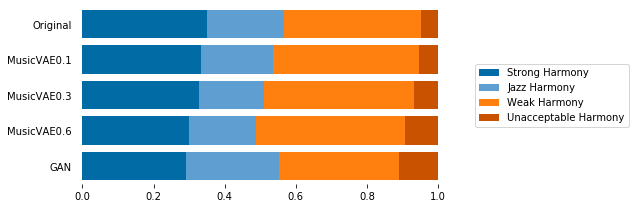

In [29]:
fig = plt.figure(figsize=(9, 3), )
ax = plt.axes(frameon=False)
plt.style.use('tableau-colorblind10')

plt.barh(tpm.index, tpm['strong'], color='C0', label='Strong Harmony'); cum = tpm['strong'].copy()
plt.barh(tpm.index, tpm['jazz'], color='C4', left=cum, label='Jazz Harmony'); cum += tpm['jazz']
plt.barh(tpm.index, tpm['weak'], color='C1', left=cum, label='Weak Harmony'); cum += tpm['weak']
plt.barh(tpm.index, tpm['unacceptable'], color='C5', left=cum, label='Unacceptable Harmony')

plt.ylim([4.5, -.5])
plt.xlim([-.02, 1.55])
plt.xticks(np.arange(0, 1.1, 0.2))
ax.tick_params(axis='y', which=u'both',length=0)

plt.legend(loc='right')
plt.tight_layout()
plt.savefig('/home/konrad/thesis/tex/figures/analysis/improvisation-harmony.pdf')